# Assignment 5 - Visualizing Data Veracity Challenges in Multi-label Classification

### Problem Statement

We have the Yeast Dataset, where each datapoint represents an experiment and the features are gene expression levels. The target is a set of 14 labels to which the gene product may belong. This dataset, even though it is standardized, still exhibits **data veracity issues** like Noisy/Ambiguous labels, Outliers and data points lying in regions where functional categories are thoroughly mixed.  
We need to apply **t-SNE and Isomap** to the feature vectors to visually expose these data quality issues, thereby understanding the challenges a classifier would face.  


In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE, Isomap

## Part A: Preprocessing and Initial Setup

### Data Loading

We have the dataset in an arff file. We need to read and parse the file before converting it into a pandas Dataframe.

#### Load the arff file and Convert into DataFrame

In [2]:
data, meta = arff.loadarff("yeast.arff")
df = pd.DataFrame(data)
df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'0'
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,b'1',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Columns: 117 entries, Att1 to Class14
dtypes: float64(103), object(14)
memory usage: 2.2+ MB


We decode the columns which have object data-type.

In [4]:
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode("utf-8")

In [5]:
df.isna().sum()

Att1       0
Att2       0
Att3       0
Att4       0
Att5       0
          ..
Class10    0
Class11    0
Class12    0
Class13    0
Class14    0
Length: 117, dtype: int64

There are **no null values** in the dataset.

#### Divide into features and labels

Divide the dataset into features and labels, the labels being the last 14 columns.

In [6]:
X = df.iloc[:, :-14]
y = df.iloc[:, -14:]

Convert the output labels into numeric values.

In [7]:
for col in y.columns:
    y[col] = pd.to_numeric(y[col])

### Dimensionality Check

In [8]:
print ("Number of features =", X.shape[1])
print ("Number of labels =", y.shape[1])
print ("Number of datapoints =", X.shape[0])

Number of features = 103
Number of labels = 14
Number of datapoints = 2417


We need to convert these label columns to numeric values

### Label Selection for Visualization

#### Find the two most frequent single-label classes.

In [9]:
label_columns = y.columns.tolist()
label_counts = y.sum()
single_label_mask = y.sum(axis=1) == 1
single_label_instances = y[single_label_mask]
single_label_counts = single_label_instances.sum()
top_single_labels = single_label_counts.nlargest(2).index.tolist()
print(top_single_labels)

['Class1', 'Class2']


#### Find most frequent multi-label combination

We need to find the most frequent multi-label combination.  
To do this, we create a new column that contains all the labels assigned to a particular datapoint and then we find out which is the most frequent element in that column.

In [10]:
# Finding most frequent multi-label combination
multi_label_mask = y.sum(axis=1) >= 2
multi_label_instances = y[multi_label_mask]

def get_label_combination(row):
    active_labels = []
    for label in label_columns:
        if row[label] == 1:
            active_labels.append(label)
    return tuple(sorted(active_labels))

multi_label_combinations = multi_label_instances.apply(get_label_combination, axis=1)
combination_counts = multi_label_combinations.value_counts()
most_frequent_combination = combination_counts.index[0]
print(most_frequent_combination)

('Class12', 'Class13', 'Class3', 'Class4')


#### Creating Categories for Visualization

In [11]:
# Creating visualization categories
def assign_visualization_category(row):
    label_count = row.sum()
    if label_count == 1:
        for label in top_single_labels:
            if row[label] == 1:
                return f"Single: {label}"
    current_combination = get_label_combination(row)
    if current_combination == most_frequent_combination:
        return f"Multi: {', '.join(most_frequent_combination)}"
    return "Other"

visualization_category = y.apply(assign_visualization_category, axis=1)
category_counts = visualization_category.value_counts()

### Scaling

#### Why scaling is crucial for distance-based techniques

Distance-based Dimensionality reduction techniques such as PCA, t-SNE and Isomap rely on distances between points to find structure in the data. If features have different scales, this can heavily skew results. The features with larger values will dominate and thus the algorithm will focus on features with larger magnitudes and ignore small-scaled ones.  
To prevent this, we need to apply Standardiztion so that every features lies approximately in the same range.

#### Applying Standardization

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

## Part B : t-SNE and Veracity Inspection

### t-SNE Implementation and Visualization

Perplexity hyperparameter in t-SNE controls the effective number of neighbors t-SNE tries to preserve. It helps control the balance between preserving local and global structure. If perplexity value is low, then each point focuses only on its closest neighbours , and if it is too high, rach point considers a larger neighborhood.  
By rule of thumb, this value should be somewhere between 5 and 50 and should be way smaller than the total number of samples.

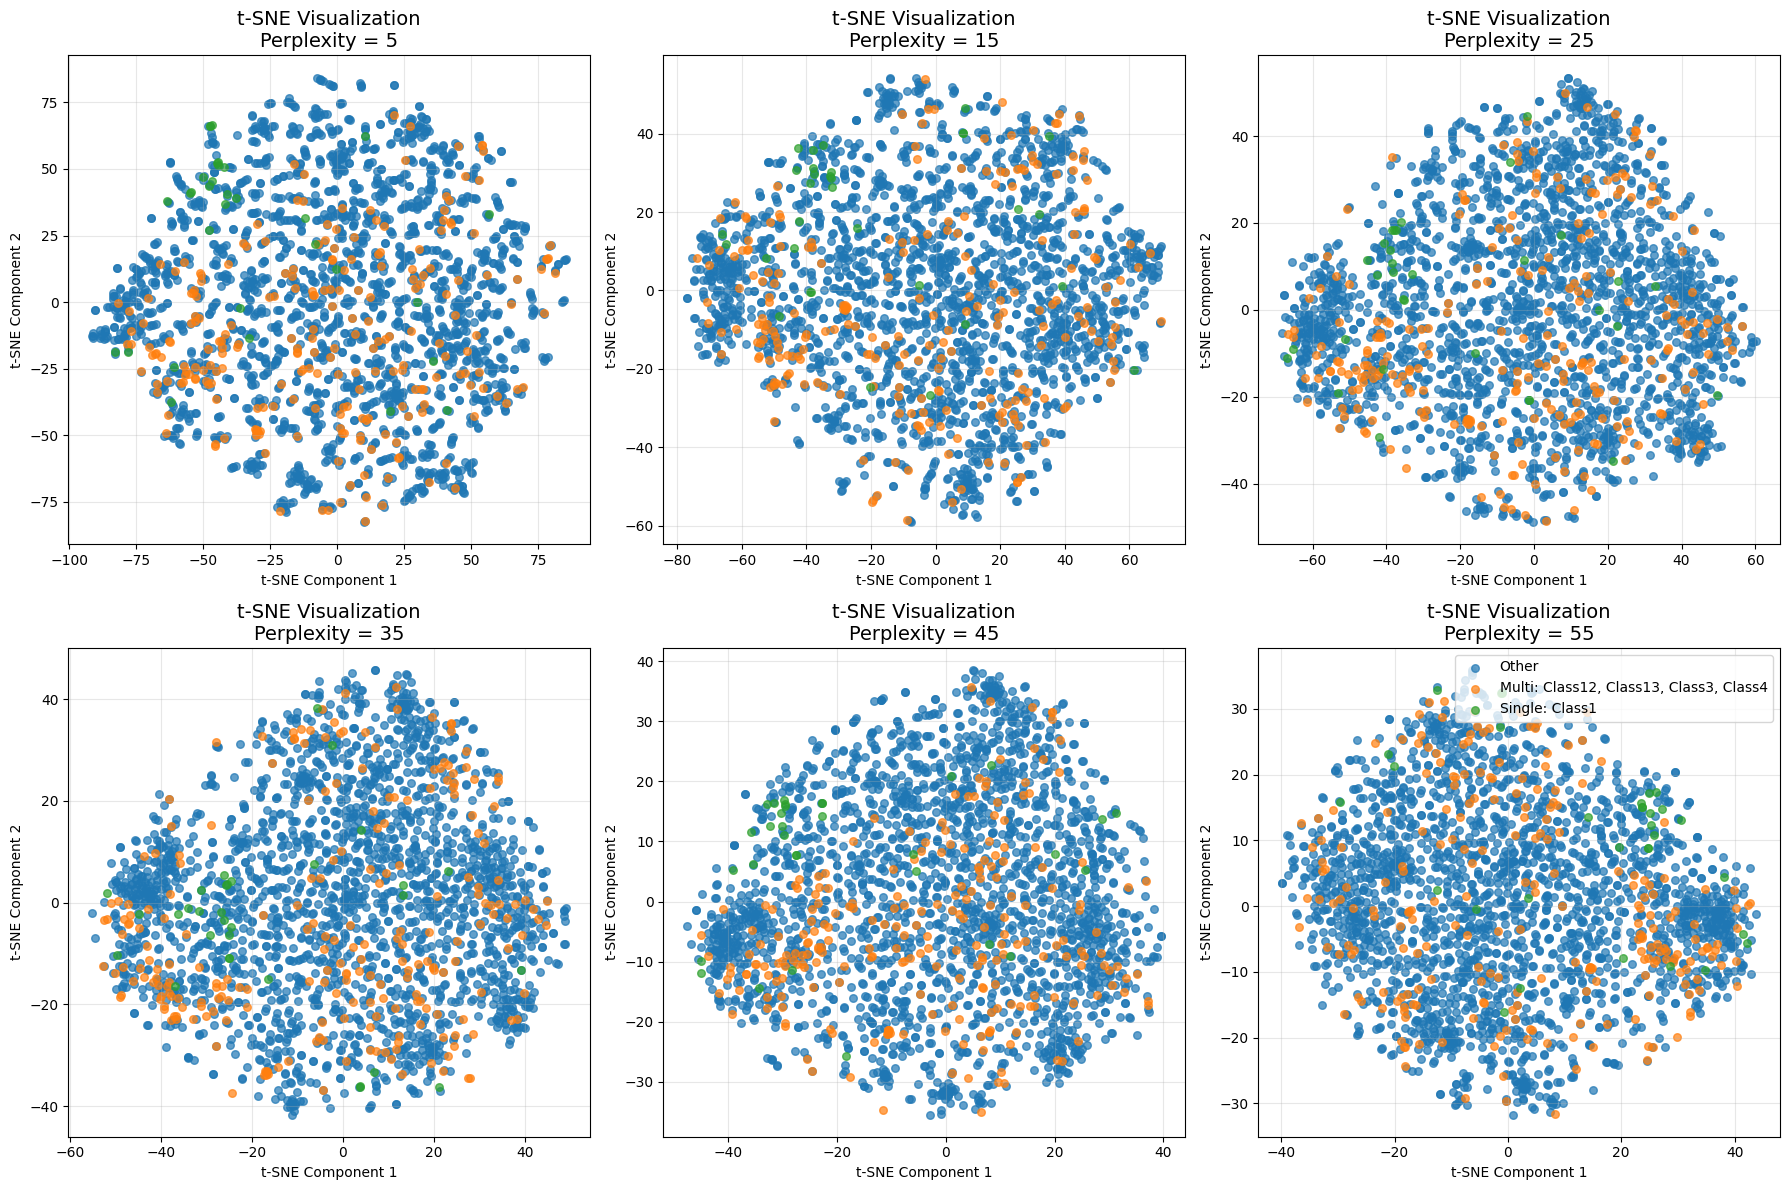

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

perplexities=[5, 15, 25, 35, 45, 55]

categories = visualization_category.unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))

tsne_results = {}

for i, perplexity in enumerate(perplexities):
    
    # Perform t-SNE
    tsne = TSNE(
        n_components = 2,
        perplexity = perplexity,
        random_state = 26)
        
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[perplexity] = X_tsne
    
    # Create scatter plot
    ax = axes[i]
    for j, category in enumerate(categories):
        mask = visualization_category == category
        ax.scatter(
            X_tsne[mask, 0], 
            X_tsne[mask, 1],
            label=category,
            alpha=0.7,
            s=30)        
    ax.set_title(f't-SNE Visualization\nPerplexity = {perplexity}', fontsize=14)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.grid(True, alpha=0.3)    
plt.tight_layout()
plt.legend()
plt.show()

#### Picking the best Perplexity value

- For perplexity values 5 and 15, the points are scattered very widely, and clusters are not clearly formed. This is because small perplexity tends to focus too much on local neighborhoods.
- For perplexity values 45 and 55, global structure starts to dominate and points are compressed towards the center, reducing the ability to distinguish clusters.
- For perplexity values 25 and 35, clusters are stabilizing and look more visible.
- Between 25 and 35, the plot with perplexity 35 has slightly more overlapping structure than 25, so 25 gives the best tradeoff since it produces coherent clusters which are visually separable.

### Applying t-SNE with chosen perplexity value

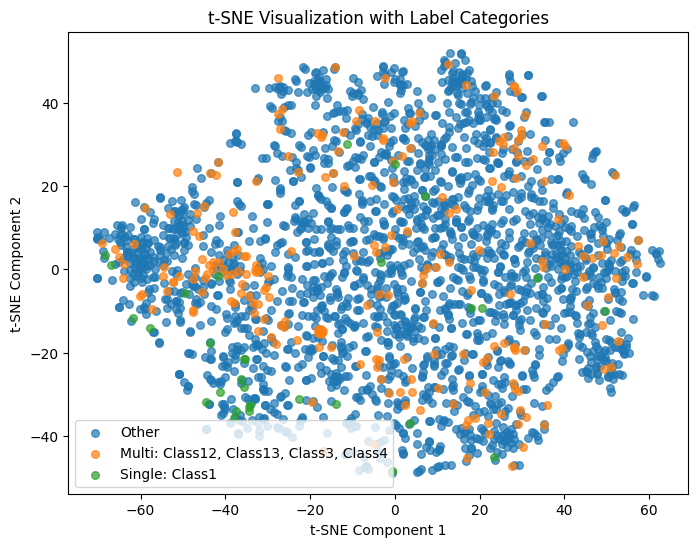

In [14]:
# Applying final t-SNE with chosen perplexity
tsne = TSNE(n_components = 2, perplexity = 25, random_state = 22)
X_tsne = tsne.fit_transform(X_scaled)

# Create colored scatter plot
plt.figure(figsize=(8, 6))
for category in visualization_category.unique():
    mask = visualization_category == category
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                label=category, alpha=0.7, s=30)
plt.title('t-SNE Visualization with Label Categories')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

### Veracity Inspection

#### Noisy and Ambiguous Labels

The green points are very sparsely distributed inside the other larger clusters. Similarly, some orange points are also embedded within the blue regions.  
These points may be mislabeled or represent borderline cases between functional categories. They introduce noise because they don't follow the main cluster structure.

#### Outliers

A few green and orange points appear at the extreme edges, like at the top-right corner and the bottom-left corner.  
These could correspond to unusual gene expression patterns or rare multi-label combinations not well represented in the dataset. They may also result from measurement errors or preprocessing artifacts.

#### Hard-to-Learn Samples

The central region of the plot shows dense mixing of blue, green, and orange points. Here, a simple classifier would struggle because the features (after t-SNE) do not clearly separate the categories.  
In these areas, functional labels may overlap in the feature space due to complex relationships, correlations, or multi-label assignments. A linear or shallow classifier would have difficulty assigning the correct labels with high confidence.

## Part C: Isomap and Manifold Learning

### Isomap Implementation

In [15]:
isomap = Isomap(n_components = 2, n_neighbors = 10)
X_isomap = isomap.fit_transform(X_scaled)

print("Shape after Isomap:", X_isomap.shape)

Shape after Isomap: (2417, 2)


### Difference between t-SNE and Isomap

Isomap and t-SNE are both powerful nonlinear dimensionality reduction methods, but they differ fundamentally in the type of structure they aim to preserve.   

**Isomap focuses on capturing the global geometric structure** of the data manifold. It **constructs a neighborhood graph based on nearby points, computes geodesic distances** (the shortest path along the manifold rather than straight-line Euclidean distances), and then applies **Multidimensional Scaling (MDS)** to embed the data in a lower-dimensional space while maintaining these global distances. This helps Isomap preserve the overall shape and topology of the data, making it suitable for datasets that lie on smooth continuous manifolds.   

In contrast, **t-SNE (t-Distributed Stochastic Neighbor Embedding) prioritizes the local neighborhood relationships**. It **converts pairwise distances into probabilities** representing how similar two points are and then optimizes the low-dimensional embedding to maintain these local similarities, often at the expense of global structure.  

Consequently, **t-SNE produces visualizations that emphasize clusters** and local groupings, while **Isomap gives a representation that reflects the overall global layout of the data manifold**.

### Visualization

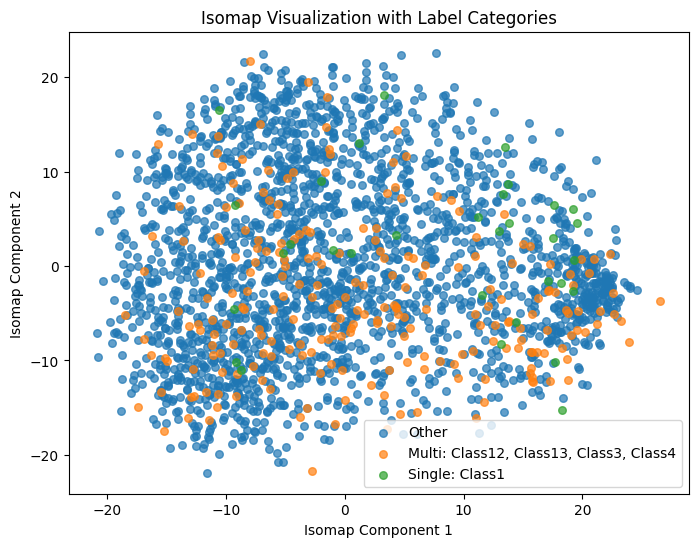

In [16]:
# Creating scatter plot with same coloring scheme
plt.figure(figsize=(8, 6))
for category in visualization_category.unique():
    mask = visualization_category == category
    plt.scatter(X_isomap[mask, 0], X_isomap[mask, 1], 
                label=category, alpha=0.7, s=30)
plt.title('Isomap Visualization with Label Categories')
plt.xlabel('Isomap Component 1')
plt.ylabel('Isomap Component 2')
plt.legend()
plt.show()

### Comparison and Curvature

#### Comparing Visualizations

**Isomap**: Preserves global geometric relationships between points by approximating geodesic distances along the data manifold. This means clusters that are far apart in high-dimensional space tend to remain far apart in the 2D embedding. You’ll see the overall shape of the data more faithfully.

**t-SNE**: Prioritizes local neighborhood preservation. It excels at forming tight, well-separated clusters, but distances between clusters can be misleading. Two clusters might appear close together even if they are far apart in high-dimensional space.

For revealing global structure, Isomap is generally better. It gives a clearer sense of how clusters relate to each other across the whole dataset, whereas t-SNE mainly emphasizes local groupings.

#### Data Manifold Analysis

Data Manifold Concept: This is the low-dimensional “surface” in high-dimensional space where your data approximately lies. Even if your gene expression data has hundreds of features, it might really vary along a few underlying dimensions.

The Isomap visualization suggests a moderately curved manifold, as evidenced by the presence of elongated, non-linear clusters and some visibly curved trajectories in the projection. The structure is neither completely random nor a simple flat arrangement, indicating that the data lies on a somewhat complex underlying surface. This complexity has direct implications for classification: the curved manifold necessitates non-linear decision boundaries, meaning that simple classifiers such as linear or logistic models are likely to fail. Additionally, regions where different functional classes are mixed reflect inherent ambiguity in gene function assignment, requiring more sophisticated approaches such as neural networks or kernel-based methods to achieve accurate classification.